In [1]:
# !git clone https://github.com/rgilman33/carlita.git
# %cd carlita
# !pip install -e .

# !pip install --upgrade wandb

In [2]:
#%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


import time
import random
import copy
from copy import deepcopy
import threading

from train_utils import *

import gym3
from procgen import ProcgenGym3Env

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
device

'cuda'

In [5]:
train_num_levels = 100_000 #500 #1500
train_start_level = 0

In [6]:
bs = 128 

env = ProcgenGym3Env(num=bs, env_name="testgame", num_levels=train_num_levels, start_level=train_start_level)

building procgen...done


In [7]:
%%time

s = np.array([[.0,.0] for _ in range(bs)], dtype=np.float32)

seq_len = 200

for i in range(seq_len):
    env.act(s)
    rew, obs, first = env.observe()
    img = obs['rgb']
    info = env.get_info()


CPU times: user 3.85 s, sys: 120 ms, total: 3.97 s
Wall time: 1.07 s


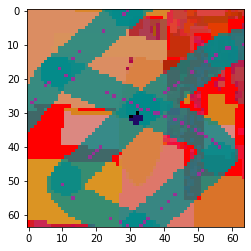

In [8]:
plt.imshow(img[10])

In [9]:
dataloader = DataLoader(env=env, bs=bs, seq_len=100)

Queueing chunk of size torch.Size([100, 128, 3, 64, 64]) took 0.45 seconds


In [10]:
front, aux, target = dataloader.get_chunk()

In [11]:
front.shape, aux.shape, target.shape

Queueing chunk of size torch.Size([100, 128, 3, 64, 64]) took 0.52 seconds


(torch.Size([100, 128, 3, 64, 64]),
 torch.Size([100, 128, 5]),
 torch.Size([100, 128, 2]))

In [12]:
#plt.hist(target[:,:,0].flatten())

In [13]:
target[:,:,0].flatten().std(), target[:,:,0].flatten().mean()

(tensor(0.5684), tensor(0.0080))

In [14]:
from torchvision import transforms
from IPython.core.display import Image as JupyterImage
from torchvision.utils import save_image

deg_to_rad = lambda x: x*0.0174533

r = 20
crop = transforms.CenterCrop(56)
resize = transforms.Resize(64)
color_jitter = transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5, hue=.5)

In [17]:
def get_rotated_view(front, aux, rotation):
    front = front.clone()
    SEQ_LEN, BS, C, H, W = front.shape
    ff = front.reshape(SEQ_LEN*BS, C, H, W)
    ff = transforms.RandomRotation([rotation,rotation])(ff)
    ff = crop(ff)
    ff = resize(ff)
    # for i in range(len(ff)):
    #    ff[i,:,:,:] = color_jitter(ff[i,:,:,:])
    ff = ff.reshape(SEQ_LEN, BS, C, H, W)
    _aux = aux.clone()
    _aux[:,:,0] -= deg_to_rad(rotation)
    return ff, _aux

In [18]:
front = front[:32]
aux = aux[:32]
front_aug, aux_aug = get_rotated_view(front, aux, 20)

TypeError: img should be PIL Image. Got <class 'torch.Tensor'>

In [19]:
torch.__version__

'1.7.1'

In [ ]:
front_aug.shape, aux_aug.shape

In [ ]:
front_aug_2, aux_aug_2 = get_rotated_view(front, aux, -20)

In [ ]:
front_aug_2.shape, aux_aug_2.shape

In [ ]:
save_image(front[0][:24].to(device), 'sample_image.png')
JupyterImage('sample_image.png')

In [ ]:
aux[0][:24,0]

In [ ]:
save_image(front_aug[0][:24].to(device), 'sample_image.png')
JupyterImage('sample_image.png')

In [ ]:
aux_aug[0][:24,0]

In [ ]:
save_image(front_aug_2[0][:24].to(device), 'sample_image.png')
JupyterImage('sample_image.png')

In [ ]:
aux_aug_2[0][:24,0]

In [ ]:
m = VizCNN(use_rnn=False).to(device);

In [ ]:
#m

In [32]:
m.load_state_dict(torch.load("m.torch"))

FileNotFoundError: ignored

In [67]:
sum([torch.numel(p) for p in m.parameters()]) / 1000

3192.834

In [93]:
with torch.no_grad():
    hidden = get_hidden(bs)
    out, hidden = m(front[:6].to(device), aux[:6].to(device), hidden)

In [ ]:
out[:,:,0]

In [70]:
#del front, aux, target, out, hidden

In [71]:
def testdrive(in_distribution=True, calibrate=False, use_training_wheels=False):
    
    TRAINING_WHEELS_WINDOW = 30
    
    t1 = time.time()
    m.eval()
    seq_len = 200
    n_val = 100
    val_env = ProcgenGym3Env(num=n_val, 
                            env_name="testgame", 
                            num_levels=train_num_levels, 
                            start_level=train_start_level if in_distribution else train_start_level+train_num_levels)
    
    s = np.array([[.0,.0] for _ in range(n_val)], dtype=np.float32)
    reward = 0
    num_collisions = 0
    wp_infractions = 0
    successful_stops = 0
    
    hidden = get_hidden(n_val)
    
    with torch.no_grad():
        for i in range(seq_len):
            val_env.act(s)
            rew, obs, first = val_env.observe()
            reward += rew.sum()
            img = obs['rgb']
            info = val_env.get_info()
            num_collisions += np.array([e['collision'] for e in info]).sum()
            wp_infractions += np.array([e['waypoint_infraction'] for e in info]).sum()
            successful_stops += np.array([e['successful_stop'] for e in info]).sum()
            
            autopilot_control = np.array([[e["autopilot_"+c] for c in control_properties] for e in info])
            
            aux = np.array([[e[a] for a in aux_properties] for e in info])

            front = torch.from_numpy(img.astype(np.float32)/255.).unsqueeze(0).permute(0,1,4,2,3).to(device)
            aux = torch.from_numpy(aux.astype(np.float32)).unsqueeze(0).to(device)
            front, aux = get_rotated_view(front, aux, 0) # so crop matches train
            
            if calibrate:
                s = autopilot_control
            else:
                out, hidden = m(front, aux, hidden)
                s = out.squeeze(0).squeeze(-1).cpu().numpy()
                s = np.clip(s, -5., 5.)
                s[:,1]=.6 # not learning throttle for now
                
            if use_training_wheels and i < TRAINING_WHEELS_WINDOW:
                s = autopilot_control
        

    reward /= (n_val*seq_len)
    num_collisions /= (n_val*seq_len)
    wp_infractions /= (n_val*seq_len)
    successful_stops /= (n_val*seq_len)
    
    val_env.close()
    m.train()
    print(f"validation took {round(time.time()-t1)} seconds")
    return reward, num_collisions, wp_infractions, successful_stops

In [72]:
testdrive(in_distribution=True, calibrate=False, use_training_wheels=True)

validation took 7 seconds


(0.1822, 0.0, 0.0, 0.0)

In [111]:
loss_fn = torch.nn.MSELoss().cuda()
scaler = torch.cuda.amp.GradScaler() 
opt = torch.optim.Adam(m.parameters(), lr=3e-4)

In [108]:
import wandb
wandb.init(project="carlita")
# #wandb.watch(m)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:

def run_epoch(train=True):
    
    start_time = time.time()
    
    # Caching baseline 'perfect' scores for val use. A bit awkward placement
    autopilot_score_baseline_in_dist, autopilot_collisions_in_dist, _, ap_successful_stops_in = testdrive(in_distribution=True, calibrate=True)
    #autopilot_score_baseline_out_dist, autopilot_collisions_out_dist, _, ap_successful_stops_out = testdrive(in_distribution=False, calibrate=True)
    
    m.train(train)
    t1 = time.time()
    epoch_loss, preds = [], []
    #bs = random.choice(list(bs_bptt_lookup.keys()))
    bptt = 1 #32 #random.choice([64, 72, 80, 88]) # increasing for 32x32 data #bs_bptt_lookup[bs]
    
    val_cadence = 4
    log_cadence = 4
    
    global dataloader, bs
    log_counter = 0
    
    while True:
        chunk = dataloader.get_chunk() # Returns a chunk instantly, begins queuing up another chunk async
        if not chunk: break
        front_container, aux_container, target_container = chunk
        chunk_len, bs, _, _, _ = front_container.shape
        len_ix = 0
        get_stats_container = lambda : {c:[] for c in ["flip_consistency_loss", "rotation_consistency_loss", "steer_pred_std","steer_pred_mean", "open_loop_loss", "output_shaping_loss"]}
        
        chunk_stats = get_stats_container()

        hidden = get_hidden(bs) # Resetting each chunk, ie each 800 steps or so. Only applicable w RNN
        
        clamp = lambda x: x #torch.clamp(x, -100, 100)

        while len_ix < chunk_len:
            
            front = front_container[len_ix:len_ix+bptt, :, :, :, :].to(device).half()
            aux = aux_container[len_ix:len_ix+bptt, :, :].to(device).half();
            target = target_container[len_ix:len_ix+bptt, :, :].to(device).half()
            len_ix += bptt

            #######################
            # # Supervised loss
            # with torch.cuda.amp.autocast():
            #     pred, hidden = m(front_aug_0, aux_aug_0, hidden)
            #     pred = clamp(pred)
            # sup_loss = loss_fn(target[:,:,1], pred[:,:,1]); 

            # max_steer = pred[:,:,1].max().item()

            with torch.no_grad():
                with torch.cuda.amp.autocast():
                    pred, hidden = m(front, aux, hidden)
                    pred = clamp(pred)
                open_loop_loss = ((target[:,:,0].detach() - pred[:,:,0])**2).mean()

            steer_pred_mean, steer_pred_std = pred[:,:,0].flatten().mean(), pred[:,:,0].flatten().std()
            #######################

            #######################
            # Unsupervised losses

            # Base image
            front_aug_0, aux_aug_0 = get_rotated_view(front, aux, 0)
            with torch.cuda.amp.autocast():
                with torch.no_grad():
                    pred_base, _ = m(front_aug_0, aux_aug_0, '')

            with torch.cuda.amp.autocast():            
                # Flip consistency
                aux_horflip = aux_aug_0.clone()
                aux_horflip[:,:,0]*=-1 # flip angle to wp
                pred_horflip, _ = m(front_aug_0.flip(-1), aux_horflip, _)
            flip_consistency_loss = loss_fn(pred_base[:,:,0], pred_horflip[:,:,0]*-1)


            # # Output shaping
            output_shaping_loss = 0

            def get_output_shaping_loss(pred):
                target_mean, target_std = 0, .77
                steer_pred_mean, steer_pred_std = pred[:,:,0].flatten().mean(), pred[:,:,0].flatten().std()
                mse = lambda x1, x2: (x1-x2)**2
                l = mse(target_std, steer_pred_std) + mse(target_mean, steer_pred_mean)
                return l
            #output_shaping_loss += get_output_shaping_loss(pred_horflip)


            # Rotation consistency 
            rotation_consistency_loss = 0
            for i in range(5):
                rotation = random.uniform(-20,20)
                front_aug_1, aux_aug_1 = get_rotated_view(front, aux, rotation)
                with torch.cuda.amp.autocast(): pred_rotate, _ = m(front_aug_1, aux_aug_1, '')
                diff = pred_rotate[:,:,0] - pred_base[:,:,0]
                diff_target = -torch.ones_like(diff) * deg_to_rad(rotation)
                rotation_consistency_loss += loss_fn(diff, diff_target)
                output_shaping_loss += get_output_shaping_loss(pred_rotate)
            
            rotation_consistency_loss /= 10
            flip_consistency_loss /= 10_000
            output_shaping_loss /= 1

            loss = rotation_consistency_loss + output_shaping_loss + flip_consistency_loss 

            chunk_stats["flip_consistency_loss"].append(flip_consistency_loss.item())
            chunk_stats["rotation_consistency_loss"].append(rotation_consistency_loss.item())
            chunk_stats["output_shaping_loss"].append(output_shaping_loss.item())
            chunk_stats["steer_pred_std"].append(steer_pred_std.item())
            chunk_stats["steer_pred_mean"].append(steer_pred_mean.item())
            chunk_stats["open_loop_loss"].append(open_loop_loss.item())

            #######################
                
            if train:
                # Scales the loss, and calls backward() to create scaled gradients 
                scaler.scale(loss).backward() 
                
                # Unscales the gradients of optimizer's assigned params in-place
                scaler.unscale_(opt)
                # Since the gradients of optimizer's assigned params are unscaled, clips as usual:
                torch.nn.utils.clip_grad_norm_(m.parameters(), 5.)
        
                # Unscales gradients and calls or skips optimizer.step() 
                scaler.step(opt) 
                # Updates the scale for next iteration 
                scaler.update() 
                opt.zero_grad()
                
            hidden = (hidden[0].detach(), hidden[1].detach())

        # Save and report at end of each chunk
        t2 = time.time()
        #chunk_loss = np.round(np.array(chunk_loss).mean(), 4)

        for cc in chunk_stats.keys(): chunk_stats[cc] = np.round(np.array(chunk_stats[cc]).mean(), 8)
        print(chunk_stats)
        print("max m param", max([p.max().item() for p in m.parameters()]))
        print("\n")

        #epoch_loss.append(chunk_loss)
        total_seconds = round(t2 - t1)
        
        if train and log_counter % log_cadence == 0 and log_counter>1: 
            
            current_time = time.time()
            torch.save(m.state_dict(), 'm.torch')
            print(f'Done with chunk. Training took {total_seconds} seconds\n')
            
        if log_counter % val_cadence == 0 and log_counter>1:
            val_score_in_dist, collisions_in_dist, wp_infractions_in_dist, stops_in = testdrive(in_distribution=True, use_training_wheels=True) 
            val_score_in_dist /= autopilot_score_baseline_in_dist
            
            chunk_stats["val score"] = np.round(val_score_in_dist,2)
            print("val score", chunk_stats["val score"])

            wandb.log(chunk_stats)
        chunk_stats = get_stats_container()
            
        t1 = t2
        log_counter+=1
    
    #loss = np.array(epoch_loss).mean()
        
    return '' #loss

In [113]:
run_epoch()

KeyboardInterrupt: ignored

In [ ]:
# Rotation consistency 
rotation = random.uniform(-20,20)
front_aug_1, aux_aug_1 = get_rotated_view(front, aux, rotation)
front_aug_2, aux_aug_2 = get_rotated_view(front, aux, -rotation)

def get_rotation_consistency_loss(front_aug_1, aux_aug_1, front_aug_2, aux_aug_2):
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            pred_rotate_1, _ = m(front_aug_1, aux_aug_1, '')
            pred_rotate_1 = clamp(pred_rotate_1)
            diff_1 = pred_rotate_1[:,:,0] - pred_base[:,:,0]

    with torch.cuda.amp.autocast():
        pred_rotate_2, _ = m(front_aug_2, aux_aug_2, '')
        pred_rotate_2 = clamp(pred_rotate_2)
        diff_2 = pred_rotate_2[:,:,0] - pred_base[:,:,0]
        rotation_consistency_loss = loss_fn(diff_1, diff_2*-1)
        #rotation_shift_loss = loss_fn((pred_rotate_1[:,:,0] + (-diff_1 * 2)), pred_rotate_2[:,:,0])
        #rotation_consistency_loss += rotation_shift_loss

    return rotation_consistency_loss